<center>
        By:
            LAAJAJ Badr &
            FETTAH Fatima-Ezzahra
</center>

## Context:
* The goal of this challenge is to develop new algorithms to detect lymph node metastases in histological images of patients diagnosed with breast cancer. 

Metastases is the term used for spread of cancer cells outside of the primary tumor. Cancer spreads from the primary site in two ways: via lymphatics and via the bloodstream. In our case study, we are working on the detection of the cancer spread in the lymphatics nodes.


![Breast cancer metastases](breat.png)
        

Therefore, The challenge proposed by Owkin is a weakly-supervised binary classification problem : predict whether a patient has any metastase in its lymph node or not, given its slide.


## Data Set : 

* The data set provided by the challenge particularly by OWKIN which is a platform that uses AI in medical research contains .jpg and .npy files as well. The jpg files correspond to a set of images for each patient and the .npy ones represent the matrix representaion for each image generated by ResNet model; a convolutional neural network.

* Our dataset has a size of 10 Go divided into train and test datasets which contain the slides .jpg files and the ResNet features as well of 279 and 120 patients respectively.

* Each patient's slide is a combination of 1000 RGB tiles of size $224*224*3$; 224 pixels and 3 channels.

#### Annotated patients: 
As we mentioned above, the challenge is a supervised binary classification which means the training observations are labeled. In our case, all the trainining patients slides that are a combination of n tiles are targetted (0/1) but just 11 patients are annotated which means every patient's tile is labeled. 

Target variable: 

for 279 patients: $patient_{i} = 0 / 1 $ i belongs to {1,2,...,279}

for 11 annotated patients: $ patient_{i} = (0,1,0,0,0,...1,1,0,1,0)$ i belongs to a set of length 11


* After exploring the data provided by the challenge,we have to organize it in such a way we group data by patient in order to build algorithms on it. 

## Libraries import: 

In [9]:
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage import io
from sklearn.preprocessing import StandardScaler

* We prepare a list of files contained in "images" folder using glob library after we read the "train_tile_annotations.csv" file that contains labels for 10124 tiles for 11 patients. 

In [2]:
files = glob.glob("./train_input_OWKIN_soqGyb9/train_input/images/*/*")
tile_annotations = pd.read_csv("./train_input_OWKIN_soqGyb9/train_input/train_tile_annotations.csv")

# Part I: Model build on annotated tiles
## Data preprocessing:


#### Tile plot: 
The image below represents the 100th tile of the patient whose id is 001. The zoom level of the image equals to 100 and the x and y coordinates refer to 74 and 156 respectively.

Text(0.5, 1.0, '100th tile of the patient 001, Zoom level:100, x:74 & y:156')

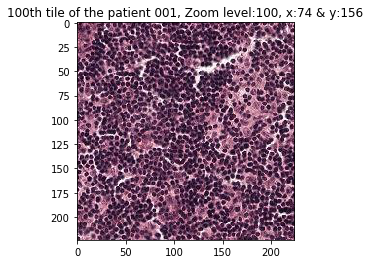

In [17]:
plt.imshow(plt.imread('./train_input_OWKIN_soqGyb9/train_input/images\\ID_001\\ID_001_tile_100_16_74_156.jpg',(224, 224, 3)))
plt.title("100th tile of the patient 001, Zoom level:100, x:74 & y:156")

In [4]:
#Getting information from image path
print(files[21210])
print(list(map(lambda x: x.split('\\')[2].split('_'), files))[21210])

./train_input_OWKIN_soqGyb9/train_input/images\ID_035_annotated\ID_035_annotated_tile_0_16_56_117.jpg
['ID', '035', 'annotated', 'tile', '0', '16', '56', '117.jpg']


<h3> "train" dataset: </h3>

- We prepare a data frame that groups patients and their tiles id, zoom level, x and y coordinates. 

In [5]:
#Dataframe for images description
train = pd.DataFrame()
train['patient_id'] = list(map(lambda x: x.split('\\')[1], files))
train['tile_id'] = list(map(lambda x: x.split('\\')[2].split('_')[3] if "annotated" not in x.split('\\')[1] else x.split('\\')[2].split('_')[4], files))
train['zoomLevel'] = list(map(lambda x: x.split('\\')[2].split('_')[4]  if "annotated" not in x.split('\\')[1] else x.split('\\')[2].split('_')[5], files))
train['xCoord'] = list(map(lambda x: x.split('\\')[2].split('_')[5]  if "annotated" not in x.split('\\')[1] else x.split('\\')[2].split('_')[6], files))
train['yCoord'] = list(map(lambda x: x.split('\\')[2].split('_')[6].split('.')[0]  if "annotated" not in x.split('\\')[1] else x.split('\\')[2].split('_')[7].split('.')[0], files))
train['image_path'] = files 
train.sample(5)

,patient_id,tile_id,zoomLevel,xCoord,yCoord,image_path
131449,ID_204,619,16,44,196,./train_input_OWKIN_soqGyb9/train_input/images...
69278,ID_113,673,16,20,85,./train_input_OWKIN_soqGyb9/train_input/images...
60212,ID_100,470,16,42,160,./train_input_OWKIN_soqGyb9/train_input/images...
41546,ID_068,47,16,83,100,./train_input_OWKIN_soqGyb9/train_input/images...
133206,ID_206,442,16,86,141,./train_input_OWKIN_soqGyb9/train_input/images...


<h3> "train_annotated" dataset: </h3>

 - The target variable which represents the labels of tiles is stored in a csv file by file_name. Therefore, we create train_annotated data which is a jointure between train and tile_annotations datasets. 

In [6]:
#Annotated tiles images dataframe
tile_annotations.sample(5)

,file_name,Target
760,ID_387_annotated_tile_760_15_32_70.jpg,0
8606,ID_036_annotated_tile_348_16_35_140.jpg,0
3223,ID_166_annotated_tile_578_15_75_67.jpg,0
1193,ID_243_annotated_tile_193_16_43_143.jpg,0
2453,ID_046_annotated_tile_808_16_18_115.jpg,0


In [8]:
#Get sorted annotated tiles from train dataframe and match them with target variable
train_annotated = train[train['patient_id'].str.contains("annotated")]
train_annotated = train_annotated.sort_values(by = ['image_path'])
y_annotated = list(tile_annotations.sort_values(by=['file_name'])['Target'])
print(len(y_annotated))
train_annotated['target'] = y_annotated 

10124


In [9]:
#train_annotated
train_annotated.sample(5) #annotated data with target variable

,patient_id,tile_id,zoomLevel,xCoord,yCoord,image_path,target
114703,ID_174_annotated,183,16,30,158,./train_input_OWKIN_soqGyb9/train_input/images...,0
22638,ID_036_annotated,606,16,39,126,./train_input_OWKIN_soqGyb9/train_input/images...,0
22001,ID_035_annotated,812,16,38,127,./train_input_OWKIN_soqGyb9/train_input/images...,0
108034,ID_166_annotated,103,15,108,50,./train_input_OWKIN_soqGyb9/train_input/images...,0
114957,ID_174_annotated,411,16,95,121,./train_input_OWKIN_soqGyb9/train_input/images...,0


## Modeling: 
### 1rst approach: 
This method consists on converting images into a vector and feed it with the target variable to a classifier. 

## Read data:

In [14]:
img = plt.imread('./train_input_OWKIN_soqGyb9/train_input/images\\ID_001\\ID_001_tile_100_16_74_156.jpg',(224, 224, 3))
img.shape

(224, 224, 3)

In [12]:
#Gray Scale
from PIL import Image
img = Image.open('./train_input_OWKIN_soqGyb9/train_input/images\\ID_001\\ID_001_tile_100_16_74_156.jpg').convert('LA')
img_tuple = np.array(img)
img_tuple.shape
img
x, y, z = img_tuple.shape
image_2d = img_tuple.reshape(x*y, z)
print(image_2d.shape)
print(image_2d)
#img.save('greyscale.png')

(50176, 2)
[[122 255]
 [161 255]
 [101 255]
 ...
 [177 255]
 [128 255]
 [122 255]]


In [13]:
#step 5 car c'est grand 50xxx
img = io.imread('./train_input_OWKIN_soqGyb9/train_input/images\\ID_001\\ID_001_tile_100_16_74_156.jpg', as_gray=True)
img = img[::1,::1]
img = img.flatten()
len(img.flatten())#flatten permet d'obtenir un array

50176

In [14]:
def img2vect(img_path):
    #image read grayscale
    img = io.imread(img_path, as_gray=True)
    img = img[::1,::1]
    img = img.flatten()    
    return img

In [15]:
train_annotated.target.value_counts()

0    9417
1     707
Name: target, dtype: int64

* We noticed that our data is unbalanced, 93 % of tiles are labeled with 0 which means there is no metastases detected and 7% are labeled with 1 that's why we choose to work with 700 observations for each label.

In [16]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
#700 de chaque label
df = shuffle(train_annotated.groupby('target').apply(lambda s: s.sample(700,random_state=123)).reset_index(drop = True)).reset_index(drop = True)
df.sample(5)

,patient_id,tile_id,zoomLevel,xCoord,yCoord,image_path,target
1168,ID_174_annotated,719,16,60,202,./train_input_OWKIN_soqGyb9/train_input/images...,0
639,ID_046_annotated,773,16,43,109,./train_input_OWKIN_soqGyb9/train_input/images...,1
355,ID_035_annotated,703,16,70,133,./train_input_OWKIN_soqGyb9/train_input/images...,1
1148,ID_174_annotated,282,16,79,141,./train_input_OWKIN_soqGyb9/train_input/images...,1
72,ID_262_annotated,529,16,59,140,./train_input_OWKIN_soqGyb9/train_input/images...,0


In [17]:
from tqdm import tqdm
X = []
for path in tqdm(df.image_path):
    vect = img2vect(path)
    #X = X.append(vect, axis = 0)
    X.append(vect.reshape(1, -1)) 
X = np.concatenate(X, axis = 0)
#matrix of each tile as row
X

100%|██████████████████████████████████████████████████████████████████████████████| 1400/1400 [00:27<00:00, 50.78it/s]


array([[0.85897608, 0.31609529, 0.08358392, ..., 0.04695137, 0.16908549,
        0.03967373],
       [0.96414039, 0.96414039, 0.96414039, ..., 0.52243451, 0.86220431,
        0.90852784],
       [0.82147255, 0.75844471, 0.33518314, ..., 0.26036784, 0.07605412,
        0.1035051 ],
       ...,
       [0.76997922, 0.63745647, 0.65536   , ..., 0.12172118, 0.0920302 ,
        0.34075569],
       [0.21976039, 0.35701529, 0.21976039, ..., 0.90858902, 0.8615302 ,
        0.68505961],
       [0.72105137, 0.63731451, 0.67542902, ..., 0.32039059, 0.76183843,
        0.96072314]])

In [18]:
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

In [19]:
X_train.shape

(938, 50176)

## Model

* After data preparation, we obtained vector representation for each image and to feed it into a classification model we reduce the size of observations first by applying a partial component analysis (PCA) and by normalizing data using a SandardScaler. 
* The final step of our pipeline is a logistic regression model.

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(),PCA(n_components = 100),LogisticRegression()) #100 comp

In [22]:
pipe.fit(X_train,y_train)

C:\Users\L.Badr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=100,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [23]:
ytrain_pred = pipe.predict_proba(X_train)
ytest_pred = pipe.predict_proba(X_test)

In [24]:
ytrain_pred

array([[0.4218367 , 0.5781633 ],
       [0.55957314, 0.44042686],
       [0.34637688, 0.65362312],
       ...,
       [0.37263759, 0.62736241],
       [0.47090064, 0.52909936],
       [0.34608236, 0.65391764]])

#### Model evaluation:
* To evaluate the performance of our model architecture, we compute the auc metric (area under curve) that takes the predicted and actual target as inputs.

In [25]:
from sklearn.metrics import roc_auc_score

In [26]:
roc_auc_score(y_train,ytrain_pred[:,1])

0.6647795481829096

In [27]:
roc_auc_score(y_test,ytest_pred[:,1])

0.5414165666266506

####  Conclusion:    
LogisticRegression results: <br/>
In img2vect function, we build a vector of pixels with differents step between them so that we reduce dimension.<br/>

For step 5: 
- train AUC score = 67.3%
- test AUC score = 52.4%

For step 1:<br/>

- train AUC score = 67.8%
- test AUC score = 52.5%

#### Random Forest classifier: 
   
* We define a new pipeline using PCA, StandardScaler and Random Forest classifier and we obtain an AUC of 68%.

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
pipe = make_pipeline(StandardScaler(),PCA(n_components = 100),RandomForestClassifier(n_estimators = 300, max_depth = 3, random_state =123))
pipe.fit(X_train,y_train)
ytrain_pred = pipe.predict_proba(X_train)
ytest_pred = pipe.predict_proba(X_test)
roc_auc_score(y_train,ytrain_pred[:,1])
roc_auc_score(y_test,ytest_pred[:,1])

#### Gradient Boosting classifier: 
* We change the third component of the pipeline used before to a gradient boosting classifier that takes different parameters as inputs. To find the optimal parameters values combination, we applied a grid search cross validation. 

In [59]:
from sklearn.model_selection import GridSearchCV

In [32]:
#-----------------------------------------------------------------------------------------------------------------
##  This code for GridCV commented to avoid running time
#-----------------------------------------------------------------------------------------------------------------
pipe = make_pipeline(StandardScaler(),PCA(n_components = 100),GradientBoostingClassifier(n_estimators = 300, max_depth = 3, learning_rate = 0.01, random_state =123))

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'gradientboostingclassifier__max_depth': [2,3,4],
    'gradientboostingclassifier__learning_rate': [0.01,0.05,0.1]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1,scoring = 'roc_auc', verbose = 1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

C:\Users\L.Badr\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:  1.3min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=100, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('gradientboostingclassifier',
                                        GradientBoostingClassifier(criteri...
                                                                   presort='auto',
                                                              

Best parameter (CV score=0.682):
{'gradientboostingclassifier__learning_rate': 0.05, 'gradientboostingclassifier__max_depth': 3}


In [33]:
#Gradient Boosting Classifier
pipe = make_pipeline(StandardScaler(),PCA(n_components = 100),GradientBoostingClassifier(n_estimators = 300, max_depth = 3, learning_rate = 0.01, random_state =123, verbose=1))
pipe.fit(X_train,y_train)
ytrain_pred = pipe.predict_proba(X_train)
ytest_pred = pipe.predict_proba(X_test)
print(roc_auc_score(y_train,ytrain_pred[:,1]))
print(roc_auc_score(y_test,ytest_pred[:,1]))

      Iter       Train Loss   Remaining Time 
         1           1.3825            2.09s
         2           1.3788            2.38s
         3           1.3752            2.37s
         4           1.3716            2.43s
         5           1.3681            2.41s
         6           1.3647            2.44s
         7           1.3613            2.42s
         8           1.3580            2.36s
         9           1.3548            2.35s
        10           1.3516            2.34s
        20           1.3221            2.04s
        30           1.2971            1.96s
        40           1.2750            1.85s
        50           1.2569            1.72s
        60           1.2404            1.59s
        70           1.2259            1.47s
        80           1.2120            1.37s
        90           1.1990            1.27s
       100           1.1862            1.19s
       200           1.0731            0.54s
       300           0.9848            0.00s


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=100,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                            learning_rate=0.01, loss='deviance',
                                            max_depth=3, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            mi

0.9273390616475722

0.6212893553223389

#### Conclusion: 
- Using the gradient boosting classifier, the auc reaches an auc of 62,12% which is an imrovement in comparison with logistic regression and radom forest classifier results.

#### XgBoost classifier: 
* We apply an other classifier called XgBoost to our preprocessed data following the same steps as before: Data normalization, dimension reduction, Grid Search cross validation, model fitting and predictions making.  

In [35]:
#-----------------------------------------------------------------------------------------------------------------
##  This code for GridCV commented to avoid running time
#-----------------------------------------------------------------------------------------------------------------
pipe = make_pipeline(StandardScaler(),PCA(n_components = 100),
                     xgb.XGBClassifier(alpha = 0.1, n_estimators = 300,max_depth = 3,objective = 'binary:logistic', learning_rate= 0.01, random_state = 123))
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'xgbclassifier__n_estimators': [200,300,400,500],
    'xgbclassifier__max_depth': [2,3,4],
    'xgbclassifier__learning_rate': [0.01,0.05,0.1]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1,scoring = 'roc_auc', verbose = 1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

C:\Users\L.Badr\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:  5.0min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=100, random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('xgbclassifier',
                                        XGBClassifier(alpha=0.1, base_score=0.5,
                                                      booster=...
                                                      reg_alpha=0, reg_lambda=1,
        

Best parameter (CV score=0.689):
{'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 200}


In [34]:
#XGBoost
import xgboost as xgb

steps = 20  # The number of training iterations
pipe = make_pipeline(StandardScaler(),PCA(n_components = 100),
                     xgb.XGBClassifier(alpha = 0.1,n_estimators = 400,max_depth = 3,objective = 'binary:logistic', learning_rate= 0.01, random_state = 123))
pipe.fit(X_train,y_train)
ytrain_pred = pipe.predict_proba(X_train)
ytest_pred = pipe.predict_proba(X_test)
roc_auc_score(y_train,ytrain_pred[:,1])
roc_auc_score(y_test,ytest_pred[:,1])

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=100,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('xgbclassifier',
                 XGBClassifier(alpha=0.1, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.01,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=400, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=123,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silen

0.9356246590289143

0.6194808845577212

# Conclusion:

We summarize the models results as follows: 

RandomForestClassifier: <br/>
    For n_estim 300, max_depth 3: 
- train AUC score = 89%
- test AUC score = 68%


GradientBoostingClassifier: <br/>
    For n_estim 300, max_depth 3, learning_rate 0.01: <br/>

- train AUC score = 92.9%
- test AUC score = 67%

GradientBostingClassifier: <br/>
    For n_estim 300, max_depth 3, learning_rate 0.01, alpha 0.1: <br/>

- train AUC score = 92.5%
- test AUC score = 67%

### 2nd approach: ResNet features 

* In this part, we work with the resnet representation provided by the challenge on the annotated patients. Therefore, we have each patient tile labeled as 0 or 1. In total, our dataset contains 10124 targetted tiles. 

In [28]:
ResNet_files = glob.glob("./train_input_OWKIN_soqGyb9/train_input/resnet_features/*")
matrix = np.load(ResNet_files[0])

In [36]:
#extract annotated files
annotated_patients = [s for s in ResNet_files if "annotated" in s]
def get_patient_matrix(path):
    #get matrix of these patients
    ID = path.split('\\')[1].split('.')[0]
    tiles_index = train_annotated[train_annotated.patient_id == ID].tile_id
    matrix = np.load(path)
    matrix = np.delete(matrix,[0,1,2],axis = 1)
    #tiles_index.values.astype(int)
    #matrix[tiles_index.values.astype(int)]
    y_annotated = train_annotated[train_annotated.patient_id == ID].target.astype(int)
    y_annotated = np.array(y_annotated).reshape(-1,1)
    matrix = np.hstack((matrix,y_annotated))
    return matrix

matrix = np.array([])
for path in annotated_patients:
    mat = get_patient_matrix(path)
#     matrix = np.vstack([matrix, mat]) 
    matrix = np.vstack([matrix, mat]) if matrix.size else mat

- The problem of the unbalance between te labels occurs again. Threfore, we work with 707 positive tiles and negative ones as well. 

In [37]:
matrix.shape

(10124, 2049)

In [38]:
np.count_nonzero(matrix[:,-1] == 1)

707

In [39]:
X1 = matrix[matrix[:,-1] == 1]
X0 = matrix[matrix[:,-1] == 0][np.random.randint(len(matrix[matrix[:,-1] == 0]), size=707),:]
X = np.vstack([X1,X0])
#np.random.shuffle(X)
X = shuffle(X)
print(X.shape)
print(np.count_nonzero(X[:,-1] == 0))

(1414, 2049)
707


In [40]:
y = X[:,-1]
X = np.delete(X,-1,axis = 1) #delete target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123) #pay attention for % of categories
print(X_train.shape)
print(y_train.shape)

(947, 2048)
(947,)


#### a. Random Forest Classifier: 

* Before feeding the data to the random forest classifier, we search for the best parameters values using a grid search cross validation. 

In [43]:
#-----------------------------------------------------------------------------------------------------------------
##  This code for GridCV commented to avoid running time
#-----------------------------------------------------------------------------------------------------------------
pipe = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state =123))
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'randomforestclassifier__n_estimators': [200,300,400],
    'randomforestclassifier__max_depth': [2,3,4]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1,scoring = 'roc_auc', verbose = 1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

C:\Users\L.Badr\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    6.7s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=3,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_dec

Best parameter (CV score=0.802):
{'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 300}


In [41]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
pipe = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators = 400, max_depth = 4, random_state =123))
pipe.fit(X_train,y_train)
ytrain_pred = pipe.predict_proba(X_train)
ytest_pred = pipe.predict_proba(X_test)
print(roc_auc_score(y_train,ytrain_pred[:,1]))
print(roc_auc_score(y_test,ytest_pred[:,1]))

0.7984042553191488

* Using a Random forest classifier on ResNet features of annotated patients, we reached an auc of 79.8%.

#### b. XgBoost Classifier: 
* Using the same approach, we apply this time XgBoost classifier to see if it can improve results accuracy starting by a pipeline initialization, Grid Search, model fitting and mking predictions.

In [45]:
#-----------------------------------------------------------------------------------------------------------------
##  This code for GridCV commented to avoid running time
#-----------------------------------------------------------------------------------------------------------------
pipe = make_pipeline(StandardScaler(), xgb.XGBClassifier(alpha = 0.1, n_estimators = 300,max_depth = 4,objective = 'binary:logistic', learning_rate= 0.01, random_state = 123))
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'xgbclassifier__n_estimators': [200,300,400],
    'xgbclassifier__max_depth': [2,3,4],
    'xgbclassifier__learning_rate': [0.01,0.05,0.1]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1,scoring = 'roc_auc', verbose = 1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

C:\Users\L.Badr\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  6.0min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('xgbclassifier',
                                        XGBClassifier(alpha=0.1, base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
                                                      learning_rate=0.01,
                                                      max_del

Best parameter (CV score=0.807):
{'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 200}


In [50]:
#XGBoost
import xgboost as xgb

pipe = make_pipeline(StandardScaler(), xgb.XGBClassifier(alpha = 0.01,n_estimators = 200,max_depth = 4,objective = 'binary:logistic', learning_rate= 0.05, random_state = 123))
pipe.fit(X_train,y_train)
ytrain_pred = pipe.predict_proba(X_train)
ytest_pred = pipe.predict_proba(X_test)
print(roc_auc_score(y_train,ytrain_pred[:,1]))
print(roc_auc_score(y_test,ytest_pred[:,1]))

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgbclassifier',
                 XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.05,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=None,
                               n_estimators=200, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=123,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

1.0

0.805309896884518

* The results generated by Xgboost classifier taking as input ResNet features are better than the ones generated before, however we notice that xgboost overfit easily on this data. 

### Problem:
In this step, our predictions for each patient are represented in a vector of 0 and 1 values. The question that arises is: Based on this set of 0 and 1 labels per tile, how can we make predictions on patients. 

# Patient prediction:
### Solution1: Build classification model that predicts the target variable based on tiles probabilities:

####  Data preparation: 

* We build a matrix where each column is a prediction of tile probability for each patient so that we feed it with the target variable to our classifiers. Therefore, we get for each patient a vector of size 1000 (number of tiles). 

In [42]:
output = pd.read_csv('./train_input_OWKIN_soqGyb9/training_output_bis_EyawEvU.csv')
#output

In [43]:
def get_patient_probabilities(path):
    matrix = np.load(path)
    matrix = np.delete(matrix,[0,1,2],axis = 1)
    y_pred = pipe.predict_proba(matrix)[:,1]
    return y_pred

In [69]:
data = np.array([])
#build matrix of probabilities where each patient in a row with its target variable
for path in tqdm(ResNet_files):
    tiles_prob = []
    #len(get_patient_probabilities(path))
    tiles_prob = list(get_patient_probabilities(path))
    if len(tiles_prob)<1000:
        if len(tiles_prob)<=700:
            continue
        else:
            tiles_prob.extend([np.mean(tiles_prob)]*(1000-len(tiles_prob)))
    #len(tiles_prob)
    if "annotated" not in path:
        ID = int(path.split('ID_')[1].split('.')[0])
    else:
        ID = int(path.split('ID_')[1].split('.')[0].split('_')[0])
    y = output[output.ID == ID].Target
    tiles_prob.extend(y)
    #tiles_prob
    data = np.vstack([data, np.array(tiles_prob)]) if data.size else np.array(tiles_prob)
data.shape

100%|████████████████████████████████████████████████████████████████████████████████| 279/279 [01:00<00:00,  5.13it/s]


(240, 1001)

In [70]:
pd.DataFrame(data).sample(5)

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
7,0.421309,0.324834,0.344498,0.273470,0.238431,0.278713,0.465816,0.336237,0.472176,0.472607,...,0.323353,0.458082,0.317775,0.560754,0.288111,0.463908,0.472344,0.270067,0.572407,0.0
161,0.450182,0.425194,0.504469,0.476174,0.386995,0.461179,0.467531,0.520732,0.548074,0.349564,...,0.569387,0.417787,0.465537,0.410941,0.496461,0.468428,0.461245,0.440566,0.447276,0.0
89,0.435444,0.564553,0.499328,0.528980,0.412670,0.482196,0.489695,0.482188,0.392168,0.521268,...,0.540882,0.475823,0.513664,0.495879,0.517761,0.505437,0.438637,0.502777,0.441192,1.0
6,0.534622,0.532525,0.501361,0.293159,0.442613,0.609186,0.208896,0.191119,0.463123,0.152237,...,0.518556,0.208139,0.224402,0.414885,0.548836,0.272198,0.230133,0.435345,0.225168,1.0
208,0.545566,0.556256,0.569837,0.222362,0.568528,0.703201,0.199810,0.576093,0.627343,0.657902,...,0.500590,0.521350,0.443043,0.516481,0.548419,0.275357,0.241517,0.592390,0.175131,0.0


In [71]:
y = data[:,-1]
X = np.delete(data,-1,axis = 1) #delete target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123) #pay attention for % of categories
X_train.shape

(160, 1000)

After splitting the data into train and test datasets, we apply random forest classiier and logistic regression after a grid search. 

In [60]:
#-----------------------------------------------------------------------------------------------------------------
##  This code for GridCV commented to avoid running time
#-----------------------------------------------------------------------------------------------------------------
rf= RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state =123)
param_grid = {
    'n_estimators': [10,150,200,300],
    'max_depth': [1,2,3,4]
}
search = GridSearchCV(rf, param_grid, n_jobs=-1,scoring = 'roc_auc', verbose = 1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

C:\Users\L.Badr\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    8.6s finished
C:\Users\L.Badr\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameter (CV score=0.648):
{'max_depth': 1, 'n_estimators': 300}


In [72]:
rf= RandomForestClassifier(n_estimators = 300, max_depth = 1, random_state =123)
rf.fit(X_train,y_train)
ytrain_pred = rf.predict_proba(X_train)
ytest_pred = rf.predict_proba(X_test)
print(roc_auc_score(y_train,ytrain_pred[:,1]))
print(roc_auc_score(y_test,ytest_pred[:,1]))

0.8393650793650793
0.6096794468887493


In [48]:
logReg = LogisticRegression(penalty='l2',C= 1e10,random_state=123)
logReg.fit(X_train,y_train)
ytrain_pred = logReg.predict_proba(X_train)
ytest_pred = logReg.predict_proba(X_test)
roc_auc_score(y_train,ytrain_pred[:,1])
roc_auc_score(y_test,ytest_pred[:,1])

C:\Users\L.Badr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.4404591104734577

#### Conclusion: 
* Using this solution, we obtain results of an auc of 60% - 44% which is not even close to the baseline.

### Solution2: Predict the target variable based on the statistics of tiles probabilities :

We work with predicted tiles probabilities per patient and we apply some basic statistics on it described below: 

- count: The number of tiles per petient
- mean: The mean of tiles probabilties 
- max: The maximum tile probability
- min: The minimum tile probability
- count_>0.5: We fix a threshold of probability to 0.5 and we count the number of features probabilities that takes a values greater than the threshold choosen. 
- mean_>0.5: The average of the probabilities greater than 0.5
- target_prdicted: takes 1 if count_>0.5 variable is greater than 170 otherwise it takes 0.

In [84]:
#Descriptive analysis of the results and solve the problem of teest prediction !!!! (you know the prob)
stats =pd.DataFrame()
stats['count'] = list(map(lambda x: len(x), X))
stats['mean']= list(map(lambda x: x.mean(), X))
stats['median'] = list(map(lambda x: np.mean(x), X))
stats['max'] = list(map(lambda x: np.max(x), X))
stats['min'] = list(map(lambda x: np.min(x[x>0.5]), X))
stats['count_>0.5'] = list(map(lambda x: len(x[x>0.5]), X))
stats['mean_>0.5'] = list(map(lambda x: np.mean(x[x>0.5]), X))
#stats['difference'] = (stats['max'] - stats['min'])/stats['mean_>0.5']
stats['target'] = y
stats['target_predicted'] = (stats['count_>0.5'] > 170).astype(int)

In [85]:
stats.groupby('target')['count_>0.5'].mean()
#Bizarre biaise au niveau des 1

target
0.0    134.789474
1.0    210.065421
Name: count_>0.5, dtype: float64

In [86]:
x = (stats['count_>0.5'] - 170)/40
stats['target_predicted_proba'] = 1 / (1 + np.exp(-x))

In [88]:
stats.sample(20)

,count,mean,median,max,min,count_>0.5,mean_>0.5,target,target_predicted,target_predicted_proba
224,1000,0.251965,0.251965,0.610010,0.500064,25,0.538328,0.0,0,0.025957
204,1000,0.545551,0.545551,0.779020,0.500484,697,0.598538,1.0,1,0.999998
179,1000,0.420494,0.420494,0.601977,0.500597,117,0.527704,0.0,0,0.209988
141,1000,0.438098,0.438098,0.676931,0.500023,349,0.551975,1.0,1,0.988738
40,1000,0.307659,0.307659,0.639125,0.501623,70,0.536116,0.0,0,0.075858
191,1000,0.487239,0.487239,0.749877,0.500166,526,0.591493,1.0,1,0.999864
57,1000,0.325039,0.325039,0.674409,0.500778,84,0.543645,0.0,0,0.104331
214,1000,0.396795,0.396795,0.691036,0.500069,223,0.546736,1.0,1,0.790012
207,1000,0.445548,0.445548,0.596607,0.500014,177,0.525210,0.0,1,0.543639
56,1000,0.493034,0.493034,0.784258,0.501362,539,0.625998,1.0,1,0.999901


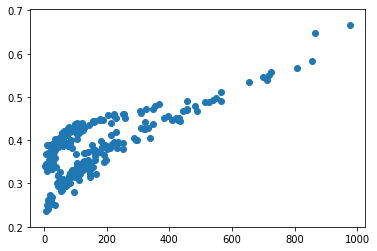

In [89]:
plt.scatter(stats['count_>0.5'],stats['mean'])

In [90]:
from sklearn.metrics import accuracy_score, confusion_matrix
print(accuracy_score(stats.target,stats.target_predicted))
confusion_matrix(stats.target,stats.target_predicted)

0.5875


array([[100,  33],
       [ 66,  41]], dtype=int64)

* We make predictions based on the statistical metrics we mentioned above and we compare it with the provided patients targets and we reach an accuracy of 58.75%.

### Solution3:  Embeddings (ResNet on each patient):

* This solution consists on making the sum  on rows that refer to tiles. So, each patient is represented by a vector of 2049 size where the first 2048th components  represent the number of ResNet features and the last one refers to the label of the patient.


In [ ]:
#Modeeel
data = np.array([])
patients = []
for path in tqdm(ResNet_files):
    matrix = np.load(path)
    matrix = np.delete(matrix,[0,1,2],axis = 1) 
    patient_weights = list(np.sum(matrix,axis=0))
    if len(patient_weights)<1000:
        continue
    if "annotated" not in path:
        ID = int(path.split('ID_')[1].split('.')[0])
    else:
        ID = int(path.split('ID_')[1].split('.')[0].split('_')[0])
    y = output[output.ID == ID].Target
    patient_weights.extend(y)
    data = np.vstack([data, np.array(patient_weights)]) if data.size else np.array(patient_weights)
data.shape

In [192]:
y = data[:,-1]
X = np.delete(data,-1,axis = 1) #delete target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123) #pay attention for % of categories
X_train.shape

(279, 2048)

(186, 2048)

(186,)

#### a. Random Forest Classifier: 
* We apply a random forest classifier following the same steps mentioned above; pipeline definition, parameters setting, model fitting and predictions making.

In [194]:
#-----------------------------------------------------------------------------------------------------------------
##  This code for GridCV commented to avoid running time
#-----------------------------------------------------------------------------------------------------------------
pipe = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state =123))
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'randomforestclassifier__n_estimators': [200,300,400],
    'randomforestclassifier__max_depth': [2,3,4]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1,scoring = 'roc_auc', verbose = 1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

C:\Users\L.Badr\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    8.2s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=3,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               min_impurity_dec

Best parameter (CV score=0.694):
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 200}


In [227]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
pipe = make_pipeline(StandardScaler(),RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state =123))
pipe.fit(X_train,y_train)
ytrain_pred = pipe.predict_proba(X_train)
ytest_pred = pipe.predict_proba(X_test)
roc_auc_score(y_train,ytrain_pred[:,1])
roc_auc_score(y_test,ytest_pred[:,1])

Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='l2')),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=3,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=200, n_jobs=None,
                                        oob_score=False, random_state=123,
                                        verbose=0, warm_start=False))],
         verbose=False)

0.9947612085769981

0.7278301886792452

* Using a random forest classifier, we obtained results 72% accurate.

#### b. XgBoost Classifier:

In [ ]:
#-----------------------------------------------------------------------------------------------------------------
##  This code for GridCV commented to avoid running time
#-----------------------------------------------------------------------------------------------------------------
pipe = make_pipeline(StandardScaler(), xgb.XGBClassifier(alpha = 0.1, n_estimators = 300,max_depth = 4,objective = 'binary:logistic', learning_rate= 0.01, random_state = 123))
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'xgbclassifier__n_estimators': [200,300,400],
    'xgbclassifier__max_depth': [2,3,4],
    'xgbclassifier__learning_rate': [0.01,0.05,0.1]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1,scoring = 'roc_auc', verbose = 1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [241]:
#XGBoost
from sklearn.preprocessing import Normalizer
import xgboost as xgb

pipe = make_pipeline(Normalizer(), xgb.XGBClassifier(alpha = 0.01,n_estimators = 400,max_depth = 2,objective = 'binary:logistic', learning_rate= 0.1, random_state = 123))
pipe.fit(X_train,y_train)
ytrain_pred = pipe.predict_proba(X_train)
ytest_pred = pipe.predict_proba(X_test)
roc_auc_score(y_train,ytrain_pred[:,1])
roc_auc_score(y_test,ytest_pred[:,1])

Pipeline(memory=None,
         steps=[('normalizer', Normalizer(copy=True, norm='l2')),
                ('xgbclassifier',
                 XGBClassifier(alpha=0.01, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=2,
                               min_child_weight=1, missing=None,
                               n_estimators=400, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=123,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

1.0

0.6915094339622642

*  We reach an auc score of 0.69 which is much better than making prediction by ResNet features directly on tiles, like we did before.

#### c.  Stacking: 

In order to improve results quality, we apply stacking technique in which we combine different classifiers to output a set of predictions; subsequently, we will train a second classifier on those predictions.
* The Stacking technique aims to reduce generalisation errors of classifications.

Let’s examine a scenario in which we want to build a 2-level stacking classifier. By "2-level classifier", what we mean is a collection of classifiers that all train on the same dataset and output predictions as level 1. Those predictions are then fed into a single classifier algorithm that make up level 2. This allows the second level learner to get a more complete view of the feature space than it would normally get.

* To build level 1, we start by training a collection of base learners. we are going to use XGBClassifier, SVC, Linear Discriminant Analysis and Random Forest.
* For the level 2, we choose to train LogisticRegression.

In [294]:
# Classifiers
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mlxtend.classifier import StackingCVClassifier # stacking

In [295]:
# Initializing XGB classifier
classifier1 = xgb.XGBClassifier(alpha = 0.01,n_estimators = 400,max_depth = 2,objective = 'binary:logistic', learning_rate= 0.1, random_state = 123)


# Initializing SVC classifier
classifier2 = SVC(random_state=123,probability=True) #Some modifications should be done to this one

# Initialing LinearDiscriminantAnalysis classifier
classifier3 = LinearDiscriminantAnalysis()

# Initializing Random Forest classifier
classifier4 = RandomForestClassifier(n_estimators = 200, max_depth = 3, random_state =123)

In [301]:
# Initializing the StackingCV classifier
sclf = StackingCVClassifier(classifiers = [classifier1, classifier2, classifier3, classifier4],
                            shuffle = False,
                            use_probas = True,
                            cv = 5,
                            meta_classifier = LogisticRegression())

In [302]:
# Create list to store classifiers
classifiers = {"XGBC": classifier1,
               "SVC": classifier2,
               "LDA": classifier3,
               "RF": classifier4,
               "Stack": sclf}

In [ ]:
# Train classifiers
for key in tqdm(classifiers):
    # Get classifier
    classifier = classifiers[key]
    
    # Fit classifier
    classifier.fit(X_train, y_train)
        
    # Save fitted classifier
    classifiers[key] = classifier

In [304]:
# Get results
results = pd.DataFrame()
for key in tqdm(classifiers):
    # Make prediction on test set
    y_pred = classifiers[key].predict_proba(X_test)[:,1]
    
    # Save results in pandas dataframe object
    results[f"{key}"] = y_pred

# Add the test set to the results object
results["Target"] = y_test


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.60it/s]

Text(0.05, 0.95, 'AUC: 0.752')

Text(0.5, 1.0, 'XGBC Distribution')

(0, 1)

Text(0.5, 0, 'Probability')

Text(0.05, 0.95, 'AUC: 0.500')

Text(0.5, 1.0, 'SVC Distribution')

(0, 1)

Text(0.5, 0, 'Probability')

Text(0.05, 0.95, 'AUC: 0.610')

Text(0.5, 1.0, 'LDA Distribution')

(0, 1)

Text(0.5, 0, 'Probability')

Text(0.05, 0.95, 'AUC: 0.747')

Text(0.5, 1.0, 'RF Distribution')

(0, 1)

Text(0.5, 0, 'Probability')

Text(0.05, 0.95, 'AUC: 0.742')

Text(0.5, 1.0, 'Stack Distribution')

(0, 1)

Text(0.5, 0, 'Probability')

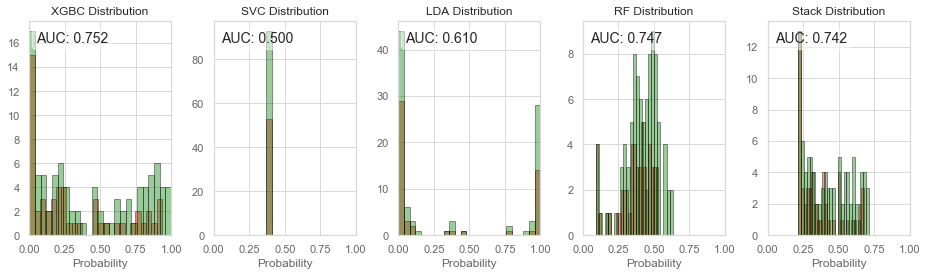

In [305]:
import seaborn as sns
# Probability Distributions Figure
# Set graph style
sns.set(font_scale = 1)
sns.set_style({"axes.facecolor": "1.0", "axes.edgecolor": "0.85", "grid.color": "0.85",
               "grid.linestyle": "-", 'axes.labelcolor': '0.4', "xtick.color": "0.4",
               'ytick.color': '0.4'})

# Plot
f, ax = plt.subplots(figsize=(13, 4), nrows=1, ncols = 5)

for key, counter in zip(classifiers, range(5)):
    # Get predictions
    y_pred = results[key]
    
    # Get AUC
    auc = roc_auc_score(y_test, y_pred)
    textstr = f"AUC: {auc:.3f}"

    # Plot false distribution
    false_pred = results[results["Target"] == 0]
    sns.distplot(false_pred[key], hist=True, kde=False, 
                 bins=int(25), color = 'red',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    # Plot true distribution
    true_pred = results[results["Target"] == 1]
    sns.distplot(results[key], hist=True, kde=False, 
                 bins=int(25), color = 'green',
                 hist_kws={'edgecolor':'black'}, ax = ax[counter])
    
    
    # These are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    
    # Place a text box in upper left in axes coords
    ax[counter].text(0.05, 0.95, textstr, transform=ax[counter].transAxes, fontsize=14,
                    verticalalignment = "top", bbox=props)
    
    # Set axis limits and labels
    ax[counter].set_title(f"{key} Distribution")
    ax[counter].set_xlim(0,1)
    ax[counter].set_xlabel("Probability")

# Tight layout
plt.tight_layout()

# Save Figure
plt.savefig("Probability Distribution for each Classifier.png", dpi = 1080)